In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from ipywidgets import FloatProgress
from IPython.display import display

/home/marcus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Read data
data = input_data.read_data_sets("MNIST/", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Placeholder for noisy image 
img_noisy = tf.placeholder(tf.float32, [None, 784])

# Placeholder for original image
img_original = tf.placeholder(tf.float32, [None, 784])

# Reshape the input -> [?, 28, 28, 1]
input_layer = tf.reshape(img_noisy, [-1, 28, 28, 1])

#############################################
# Encoder
#############################################

# Convolutional layer 1 -> [?, 24, 24, 32]
conv1 = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=(5, 5), padding="valid", activation=tf.nn.relu)

# Max pool -> [?, 12, 12, 32]
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional layer 2 -> [?, 8, 8, 64]
conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=(5, 5), padding="valid", activation=tf.nn.relu)

# Max pool -> [?, 4, 4, 64]
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Flatten result -> [?, 1024]
conv2_flat = tf.reshape(pool2, [-1, 4 * 4 * 64])

# Feed to dense layer 1 -> [?, 1024] 4*4*64
dense1 = tf.layers.dense(inputs=conv2_flat, units=750, activation=tf.nn.relu)

# Dense layer 2 -> [?, 100]
dense2 = tf.layers.dense(inputs=dense1, units=100, activation=tf.nn.relu)

# Reshape dense into 3D tensor -> [?, 10, 10, 1]
dense_reshaped = tf.reshape(dense2, [-1, 10, 10, 1])

#############################################
# Decoder
#############################################

# Transpose convolusion 1 -> [?, 14, 14, 32]
conv_trans_1 = tf.layers.conv2d_transpose(dense_reshaped,
                                          filters=32,
                                          kernel_size=(5, 5),
                                          strides=(1, 1),
                                          padding="valid",
                                          activation=tf.nn.relu)

# Transpose convolusion 2 -> [?, 18, 18, 64]
conv_trans_2 = tf.layers.conv2d_transpose(conv_trans_1,
                                          filters=64,
                                          kernel_size=(5, 5),
                                          strides=(1, 1),
                                          padding="valid",
                                          activation=tf.nn.relu)

# Transpose convolusion 3 -> [?, 28, 28, 1]
conv_trans_3 = tf.layers.conv2d_transpose(conv_trans_2,
                                          filters=1,
                                          kernel_size=(11, 11),
                                          strides=(1, 1),
                                          padding="valid",
                                          activation=tf.nn.relu)

# Calculate loss
loss = tf.reduce_mean(tf.pow(tf.subtract(tf.reshape(conv_trans_3, [-1, 784]), img_original), 2))

In [4]:
optim = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Make batches to train
num_iter = 1000
batch_size = 64
loss_values = []
progress = FloatProgress(min=0, max=num_iter); display(progress)
for i in range(num_iter):
    progress.description = "Epoch %i/%i" % (i, num_iter)
    
    # Get next batch
    batch_img, _ = data.train.next_batch(batch_size)
    
    # Add noise to the batch
    batch_img_noisy = np.copy(batch_img) + np.random.normal(loc=0.0, scale=0.15, size=batch_img.shape)
    
    # Do training
    _, l = sess.run([optim, loss], feed_dict={ img_noisy: batch_img_noisy, img_original: batch_img })
    loss_values.append(l)
    
    # Show progress
    progress.value += 1

A Jupyter Widget

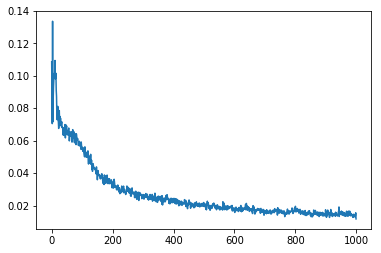

In [5]:
plt.plot(loss_values)
plt.show()

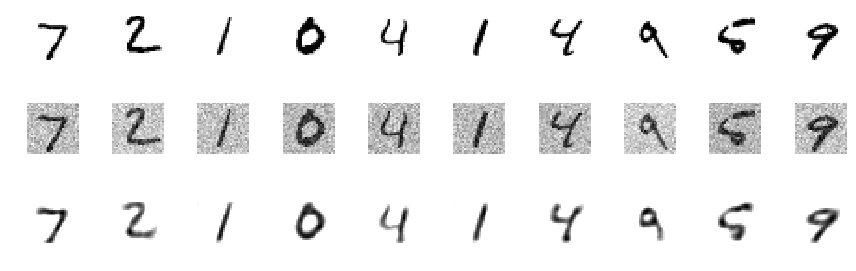

In [6]:
batch_img = data.test.images[:10]   
batch_img_noisy = np.copy(batch_img) + np.random.normal(loc=0.0, scale=0.15, size=batch_img.shape)
output_imgs = sess.run(conv_trans_3, feed_dict={ img_noisy: batch_img_noisy, img_original: batch_img })

fig, axes = plt.subplots(3, 10, figsize=(12, 4))
for i, (img_org, img_noise, img_denoise) in enumerate(zip(batch_img, batch_img_noisy, output_imgs)):
    ax = axes[0, i]
    ax.axis("off")
    ax.imshow(img_org.reshape(28, 28), cmap="binary")
                        
    ax = axes[1, i]
    ax.axis("off")
    ax.imshow(img_noise.reshape(28, 28), cmap="binary")
                        
    ax = axes[2, i]
    ax.axis("off")
    ax.imshow(img_denoise.reshape(28, 28), cmap="binary")

plt.tight_layout()